In [1]:
import scipy.optimize
import numpy as np
import pandas as pd

import os
import seaborn as sbn
import matplotlib.pyplot as plt
import numpy as np
from IPython.core.pylabtools import figsize
figsize(12, 10)
sbn.set_context("paper", font_scale=1)
sbn.set_style("whitegrid")


from NOAAStations import TidalStation
from DeviceModels import Turbine, calculate_power
from Calculator import maintenance, operation

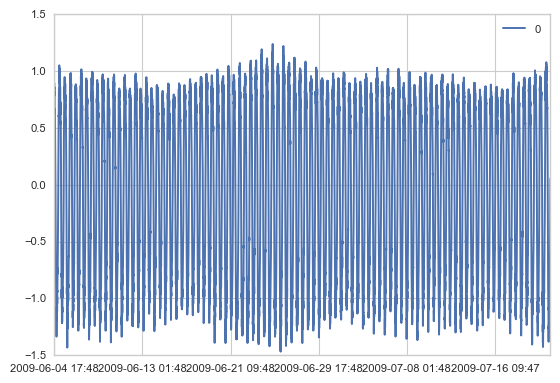

In [2]:
station_data = os.path.join('currentData', 'COD0903.pkl')

currents = pd.read_pickle(station_data)
currents.dropna()

currents['COD0903.1.s'] = pd.to_numeric(currents['COD0903.1.s'])
currents['COD0903.1.d'] = pd.to_numeric(currents['COD0903.1.d'])
speedAndDirection = pd.DataFrame(currents['COD0903.1.s'].values/100.*np.cos(currents['COD0903.1.d'].values*np.pi/180.), 
                                 index=currents.index)
                                 
plt.figure()
speedAndDirection.plot()
plt.show()

In [17]:
Bournedale = TidalStation(8447191)
time, height = Bournedale.predictWaterLevels(0, 24*30)


height_constituents = Bournedale.constituents


In [5]:
def harmonicConstituentModel(time, *hm):
    assert len(hm) % 3 == 0
    velocity = 0 
    for i in range(len(hm)//3):
        velocity += hm[3*i]*np.sin((hm[3*i+1] * time + hm[3*i+2])*np.pi/180.)
    return velocity



velocities = speedAndDirection.as_matrix()

time = np.arange(0, len(velocities))*6/60
data = np.column_stack((time, velocities[:,0]))
data = data[~np.isnan(data).any(axis=1)]

# upper_bounds = []
# starting_guess = []

# for keys, dicts in height_constituents.items():
#     starting_guess.append(float(dicts['Amplitude']))
#     upper_bounds.append(np.inf)
#     starting_guess.append(float(dicts['Speed']))
#     upper_bounds.append(360)
#     starting_guess.append(float(dicts['Phase']))
#     upper_bounds.append(360)

# lower_bounds = [0]*len(upper_bounds)    
# param_bounds = (lower_bounds, upper_bounds)
# starting_guess = tuple(starting_guess)

# optimized_parameters, covariance = scipy.optimize.curve_fit(harmonicConstituentModel, 
#                                                              xdata = data[:,0], 
#                                                              ydata = data[:,1],
#                                                              bounds = param_bounds,
#                                                              p0 = starting_guess)

        
# print(optimized_parameters)


In [55]:
with open('HM-COD0903.txt','w') as myFile:
    for i in range(len(optimized_parameters)//3):
        myFile.write('{},{},{}\n'.format(optimized_parameters[3*i],optimized_parameters[3*i+1], optimized_parameters[3*i+2]))
    

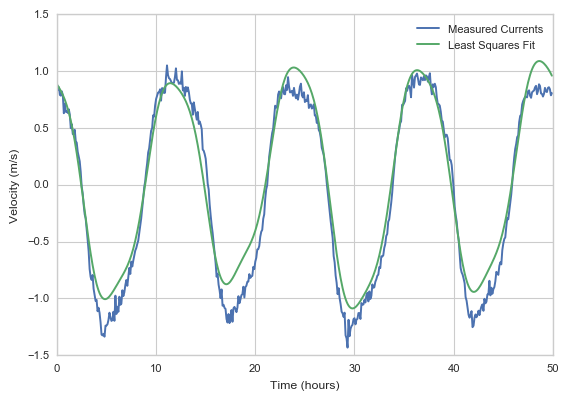

In [6]:
def harmonicConstituentModel(time, *hm):
    assert len(hm) % 3 == 0
    velocity = 0 
    for i in range(len(hm)//3):
        velocity += hm[3*i]*np.sin((hm[3*i+1] * time + hm[3*i+2])*np.pi/180.)
    return velocity


station_data = os.path.join('currentData', 'COD0903.pkl')

currents = pd.read_pickle(station_data)
currents.dropna()

currents['COD0903.1.s'] = pd.to_numeric(currents['COD0903.1.s'])
currents['COD0903.1.d'] = pd.to_numeric(currents['COD0903.1.d'])
speedAndDirection = pd.DataFrame(currents['COD0903.1.s'].values/100.*np.cos(currents['COD0903.1.d'].values*np.pi/180.), 
                                 index=currents.index)
                                 
plt.figure()
speedAndDirection.plot()
plt.show()



t = np.arange(0, 50, .1)
optimized_parameters = []
with open('HM-COD0903.txt','r') as myFile:
    for line in myFile:
        amplitude, speed, phase  = line.split(',')
        optimized_parameters.append(float(amplitude))
        optimized_parameters.append(float(speed))
        optimized_parameters.append(float(phase))
        
graph2 = harmonicConstituentModel(t, *optimized_parameters)
plt.plot(data[:500,0], data[:500,1], label='Measured Currents')
plt.plot(t, graph2, label='Least Squares Fit')
plt.legend(loc='best')
plt.xlabel('Time (hours)')
plt.ylabel('Velocity (m/s)')
plt.show()
